# Calculating Odds on Over/Under Number of Generations By Map

(well, by cup, and by map...)

This notebook uses the exponential distribution function to analyze the average number of generations of Golly matches by map, and obtain a mechanism for calculating the expected number of generations for a match to be completed, the probability of waiting less than or more than a certain number of generations for the match to be completed, etc.

In [1]:
import os, sys, subprocess, json, time
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
xkcd_colors = sns.xkcd_rgb
GOLLY_GRAY = "#272B30"

## Loading Match Data

Start by loading match data from the `data/` dir:

In [3]:
def fetch_season_data(cup, which_season0):
    cup = cup.lower()
    seas_file = os.path.join('..', 'data', f'gollyx-{cup}-data', f'season{which_season0}', 'season.json')
    if not os.path.exists(seas_file):
        raise Exception(f"Error: season {which_season0} not valid: {seas_file} does not exist")
    with open(seas_file, 'r') as f:
        season0_seas = json.load(f)
    return season0_seas

In [4]:
def fetch_postseason_data(cup, which_season0):
    cup = cup.lower()
    post_file = os.path.join('..', 'data', f'gollyx-{cup}-data', f'season{which_season0}', 'postseason.json')
    if not os.path.exists(post_file):
        raise Exception(f"Error: season {which_season0} not valid: {post_file} does not exist")
    with open(post_file, 'r') as f:
        season0_post = json.load(f)
    return season0_post

## Test drive

We use the methods above to extract point totals and splits for each game, and collate it by map.

In [5]:
season0 = 3
sdat = fetch_season_data('klein', season0)
pdat = fetch_postseason_data('klein', season0)

print(len(sdat))

11


In [6]:
# # Print a sample game
# pprint(sdat[0][0])

# Get info about the map
# print(sdat[0][0]['map'].keys())
print(sdat[0][0]['map']['mapName'])

# Get the length of the match
print(sdat[0][0]['generations'])

East Hellmouth's Revenge
4099


## Method to assemble number of generations by map name

Compile methods to extract and compile length, given either a season and a postseason data structure.

Then iterate over each season number, request the data, and compile the lengths.

In [7]:
def extract_ngenerations(_game, _totals):
    map_name = _game['map']['mapName']
    gens = _game['generations']

    if map_name not in _totals:
        _totals[map_name] = []

    _totals[map_name].append(gens)

In [10]:
def compile_gens_by_map(season_dat, postseason_dat, totals={}):

    # Season first
    for day in season_dat:
        for game in day:
            extract_ngenerations(game, totals)

    # Postseason second
    for series in postseason_dat:
        miniseason = postseason_dat[series]
        for day in miniseason:
            for game in day:
                extract_ngenerations(game, totals)
    
    return totals

### Try it out on a single season

Here is what the above method returns when run on a single season:

In [11]:
season0 = 0
sdat = fetch_season_data('klein', season0)
pdat = fetch_postseason_data('klein', season0)
totals = compile_gens_by_map(sdat, pdat)
pprint(totals)

{'Because Math': [3931, 2612, 1910, 3304, 2498, 3331, 2824, 3052, 4195],
 'Carcinization': [4016, 1808, 1001, 1122, 4625],
 'Charlie Foxtrot': [2466, 1871, 9317, 1936, 3726, 2902, 10168],
 'Crash and Burn': [1053,
                    1693,
                    4211,
                    5864,
                    3093,
                    1288,
                    2929,
                    2081,
                    1202,
                    1062,
                    4101],
 'Donut Hot Tub': [2223, 2166, 1390, 4130, 3223],
 'Double Rainbow': [4943, 3259, 2179, 5683, 1840],
 'East Hellmouth': [2448, 2958, 3041],
 "East Hellmouth's Revenge": [5297, 2177, 3246, 1833, 4046],
 'Engine Room': [2645, 3178, 1782, 1704, 2841],
 'Fistfight at the Opera': [2141, 2324],
 'Justyna': [1943, 2522, 1107, 7513, 2129],
 'Morning Commute': [1965, 1399, 1440, 1059, 3322, 1818, 2569, 1536],
 'Parking Garage': [2361, 1428, 2704],
 'Rabbit Farm': [2069, 1576, 1698, 3906, 3047],
 'Spacetime Complex': [1859, 1805,

### Try it out on multiple seasons

If we don't pass in a totals/diffs counter dictionary, then the method will automatically create an empty dictionary to start with, and manage that for us.

But we can also pass in our own totals/diffs counter dictionary, one that is accumulating totals from across multiple seasons.

In [12]:
totals = {}
diffs = {}
for season0 in range(0, 23):
    sdat = fetch_season_data('klein', season0)
    pdat = fetch_postseason_data('klein', season0)
    compile_gens_by_map(sdat, pdat, totals)
print(totals['West Hellmouth'])

[1987, 2232, 2041, 1547, 1499, 1504, 1476, 1051, 1276, 1067, 1817, 1105, 1713, 1889, 1687, 1785, 2064, 5668, 1968, 6044, 4563, 1351, 2527, 2106, 1939, 2099, 1540, 1161, 1917, 2166, 1240, 1133, 3899, 3603, 3128, 2948, 3005, 1553, 1062, 1961, 3665, 4078, 1038, 3143, 1050, 1645, 1620, 2939, 1288, 1676, 1737, 1006, 2817, 3365, 2736, 1040, 1008, 2811, 2233, 9553, 1367, 1337, 1300, 2659, 2719, 1897, 2584, 2601, 1571, 1962, 1611, 1180, 2323, 1372, 1120, 1937, 1951, 1078, 4192, 2302, 2656, 1349, 2181, 2851, 1952, 1799, 1590, 3895, 1155, 1015, 1554, 3787, 2580, 1220, 2548, 1558, 1072, 1757, 7725, 1356, 3073, 6071, 1255, 1731, 1804, 1922, 1934, 3156, 1389, 7520, 3485, 2728, 2162, 4240, 2290, 1372, 2554, 1528, 1711, 1898, 2282, 3385, 1369, 1552, 2640, 1751, 1372, 1924, 3056, 2504, 2102, 4039, 3296, 1990, 3078, 1302, 1218, 2054, 3356, 2330, 1254, 3745]


At this point, we have a large number of N Generations (waiting times), and we want to determine what the mean wait time is, assuming the wait times follow an exponential distribution.

Exponential distributions follow the formula:

$$
f(x; \lambda) = \lambda \exp( - \lambda x )
$$

where

$$
\lambda = \frac{1}{\mu}
$$

is a rate parameter, and $\mu$ is the average wait time (number of generations).

In [36]:
import numpy as np

wh_mu = np.mean(totals['West Hellmouth'])
wh_lambda = 1.0/wh_mu
wh_lambda

0.0004344447367937979

Now, the exponential probability distribution function (pdf) follows the equation:

$$
f(x; \lambda) = \lambda \exp( - \lambda x )
$$

the cumulative distribution function (cdf) is given by:

$$
F(x; \lambda) = 1 - \exp( - \lambda x)
$$

inverse CDF given by:

$$
F^{-1}(x; \lambda) = -\frac{\ln(1 - \lambda)}{x}
$$

The cdf allows us to convert a probability (z percent of the time) to a wait time (you will wait less than N generations).

In [46]:
wh_mu

2301.788732394366

In [48]:
print(np.log(1-(1.0/wh_mu)))

-0.00043453913525003324


In [50]:
print(np.log(1-(1.0/wh_mu))/0.5)

-0.0008690782705000665


...shit.

## Toroidal Cup

In [42]:
tor_totals = {}
for season0 in range(0, 23):
    sdat = fetch_season_data('toroidal', season0)
    pdat = fetch_postseason_data('toroidal', season0)
    compile_gens_by_map(sdat, pdat, tor_totals)

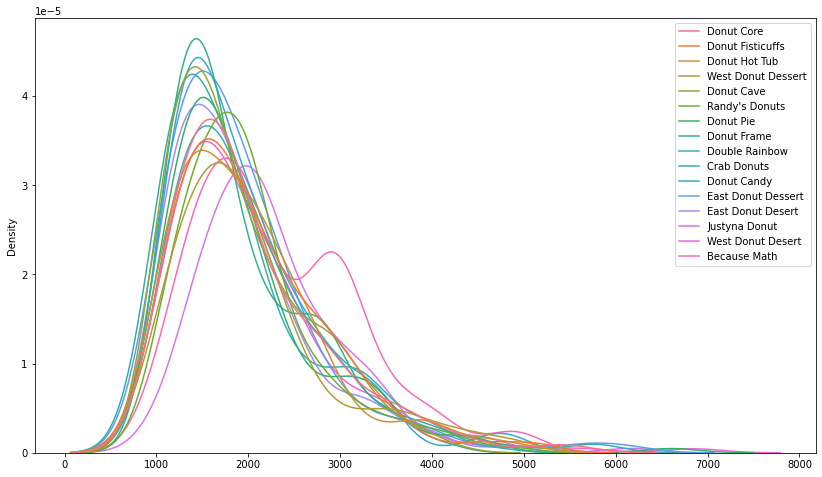

In [43]:
# This histogram plot is cool but has too much information to easily interpret...
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

sns.kdeplot(data=tor_totals, ax=ax)

plt.show()

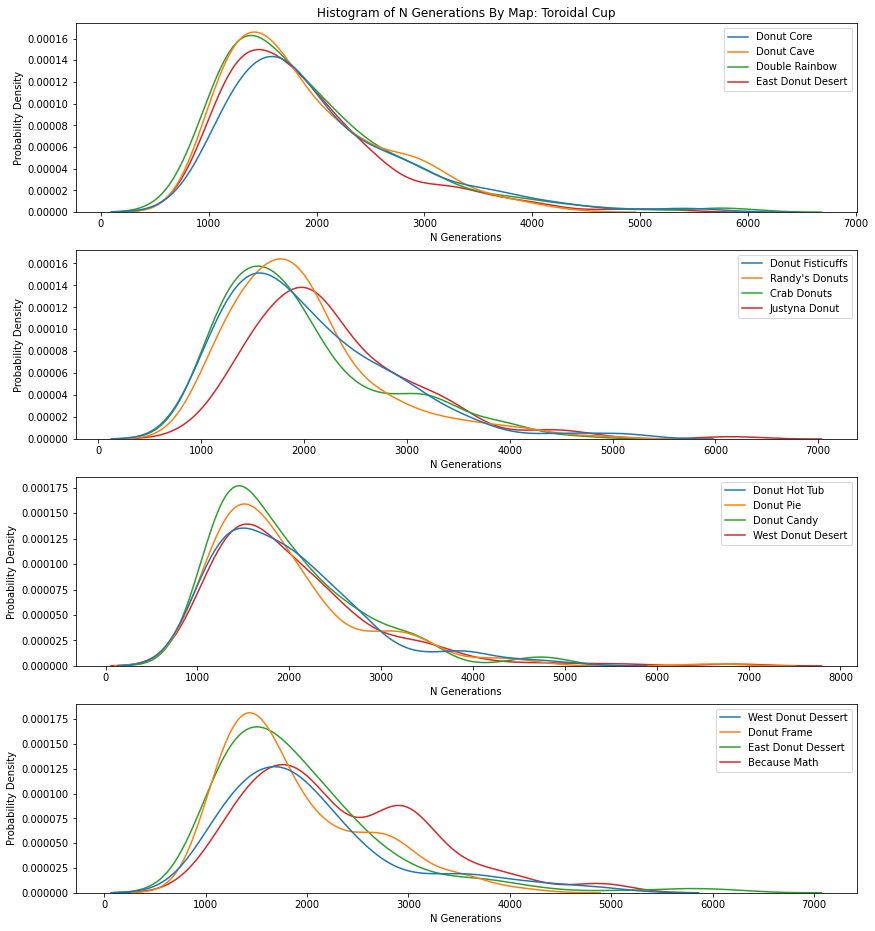

In [44]:
fig, axes = plt.subplots(4, 1, figsize=(14, 16))

# This bit of magic will iterate over all the keys in totals, and split into 4 groups
for m, aax_ in enumerate(axes):
    sns.kdeplot(data={k: v for i, (k, v) in enumerate(tor_totals.items()) if i%4==m}, ax=aax_)
    aax_.set_xlabel("N Generations")
    aax_.set_ylabel("Probability Density")

axes[0].set_title("Histogram of N Generations By Map: Toroidal Cup")
plt.show()

## Star Cup

In [45]:
star_totals = {}
for season0 in range(0, 23):
    sdat = fetch_season_data('star', season0)
    pdat = fetch_postseason_data('star', season0)
    compile_gens_by_map(sdat, pdat, star_totals)

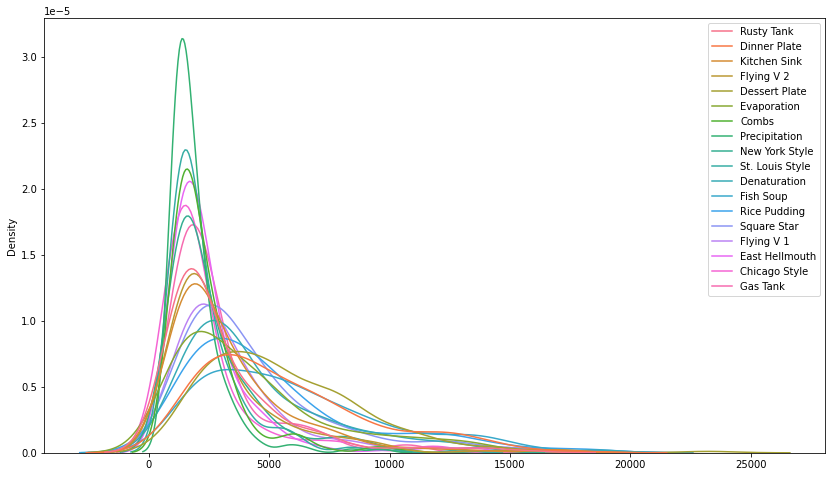

In [46]:
# This histogram plot is cool but has too much information to easily interpret...
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

sns.kdeplot(data=star_totals, ax=ax)

plt.show()

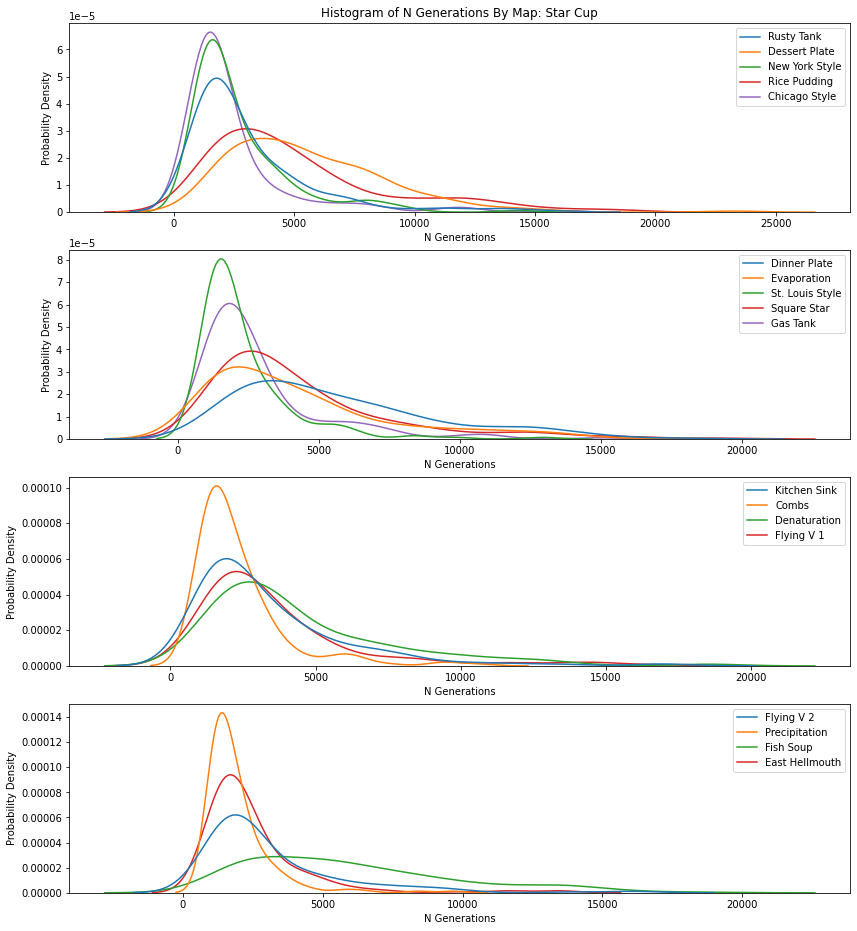

In [47]:
fig, axes = plt.subplots(4, 1, figsize=(14, 16))

# This bit of magic will iterate over all the keys in totals, and split into 4 groups
for m, aax_ in enumerate(axes):
    sns.kdeplot(data={k: v for i, (k, v) in enumerate(star_totals.items()) if i%4==m}, ax=aax_)
    aax_.set_xlabel("N Generations")
    aax_.set_ylabel("Probability Density")

axes[0].set_title("Histogram of N Generations By Map: Star Cup")
plt.show()

## Empirical CDF For Determining Split

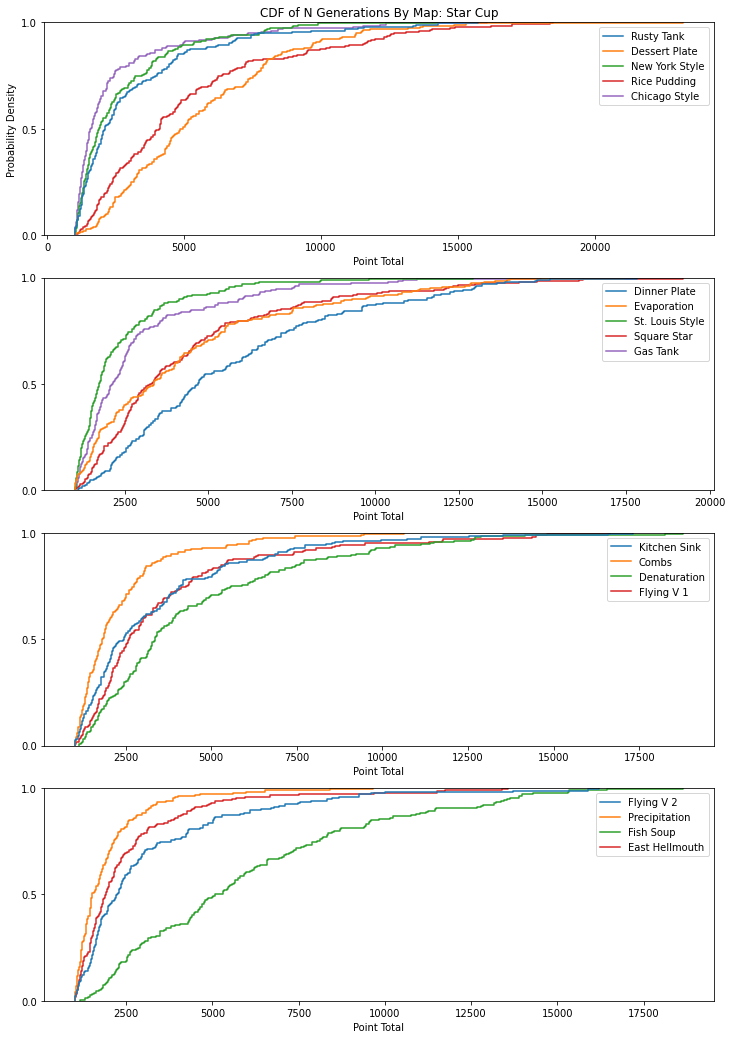

In [38]:
fig, axes = plt.subplots(4, 1, figsize=(12, 18))

# This bit of magic will iterate over all the keys in totals, and split into 4 groups
for m, aax_ in enumerate(axes):
    sns.ecdfplot(data={k: v for i, (k, v) in enumerate(star_totals.items()) if i%4==m}, ax=aax_)
    aax_.set_ylabel("")
    aax_.set_yticks([0.0, 0.5, 1.0])
    aax_.set_xlabel("N Generations")
    # aax_.set_facecolor(GOLLY_GRAY)

axes[0].set_ylabel("Probability Density")
axes[0].set_title("CDF of N Generations By Map: Star Cup")

plt.show()